# Imports
Importing all libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Readme

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)



Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1.	unit number
2.	time, in cycles
3.	operational setting 1
4.	operational setting 2
5.	operational setting 3
6.	sensor measurement  1
7.	sensor measurement  2
...

26.	sensor measurement  26


Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.


# Training data Import

### Creating column names based on the readme file

In [2]:
operational_settings = ['op_setting_{}'.format(i + 1) for i in range (3)]
sensor_columns = ['sensor_{}'.format(i + 1) for i in range(27)]
features = operational_settings + sensor_columns
metadata = ['engine_no', 'time_in_cycles']
list_columns = metadata + features

 ### Importing training data and adding headers to the table

In [3]:
raw_df = pd.read_csv('train_FD001.txt', sep = ' ', header= None, names = list_columns)
raw_df.head(2)

,engine_no,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388,100.0,39.06,23.4190,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388,100.0,39.00,23.4236,NaN,NaN,NaN,NaN,NaN,NaN


# Training data preprocessing

### Adding RUL column and reorganizing the df

In [4]:
raw_df_RUL = raw_df.groupby(['engine_no']).max()

raw_df['RUL'] = raw_df_RUL['time_in_cycles'].values[raw_df['engine_no']-1] - raw_df['time_in_cycles']

col = list(raw_df.columns)
df = raw_df[col[0:2]+[col[-1]]+col[2:32]]

### Deleting NaN and constant columns

In [5]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

C:\Users\X240\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Saving to a new file

In [6]:
df.columns
df.to_csv('preprocessed_train.csv')
df.head(2)

,engine_no,time_in_cycles,RUL,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,191,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,190,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236


# Correlation analysis

### Using Pearson correlation matrix choosing top 4 most correlated indicators

In [7]:
pearson = df.corr(method='pearson').abs()
RUL_corr = pearson.sort_values('RUL', ascending = False)
RUL_corr['RUL']

RUL               1.000000
time_in_cycles    0.736241
sensor_11         0.696228
sensor_4          0.678948
sensor_12         0.671983
sensor_7          0.657223
sensor_15         0.642667
sensor_21         0.635662
sensor_20         0.629428
sensor_2          0.606484
sensor_17         0.606154
sensor_3          0.584520
sensor_8          0.563968
sensor_13         0.562569
sensor_9          0.390102
sensor_14         0.306769
sensor_6          0.128348
engine_no         0.078753
op_setting_1      0.003198
op_setting_2      0.001948
Name: RUL, dtype: float64

### Splitting the df into x and y

In [8]:
x_col = list(df.columns)
x_col = x_col[3:-1]

x_train = df[x_col]
y_train = df['RUL']

### Deleting irrelevant data from training set

In [9]:
 df.drop(['op_setting_1', 'op_setting_2', 'engine_no', 'sensor_6', 'time_in_cycles'],inplace=True,axis=1)

C:\Users\X240\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Plotting the top 4 indicators vs RUL

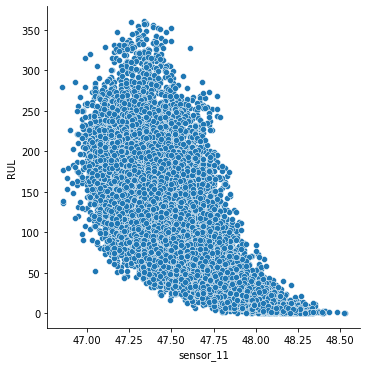

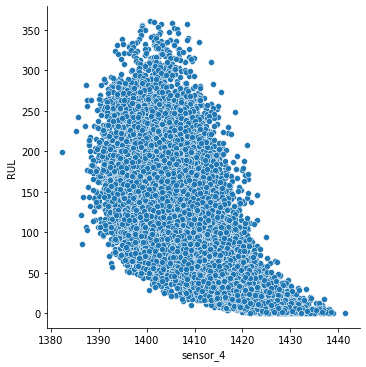

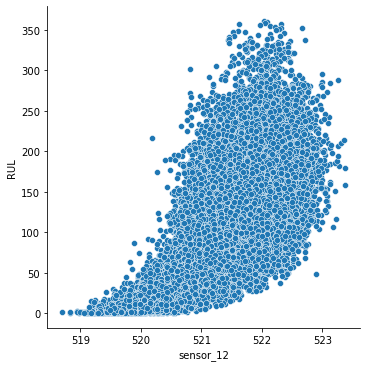

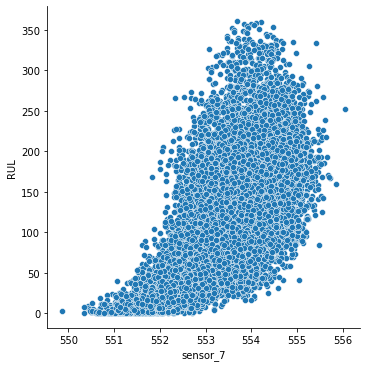

In [10]:
sns.relplot(data = df, y = 'RUL', x='sensor_11', kind = 'scatter', ci=None)
plt.savefig('RULxS11.png')
sns.relplot(data = df, y = 'RUL', x='sensor_4', kind = 'scatter', ci=None)
plt.savefig('RULxS4.png')
sns.relplot(data = df, y = 'RUL', x='sensor_12', kind = 'scatter', ci=None)
plt.savefig('RULxS12.png')
sns.relplot(data = df, y = 'RUL', x='sensor_7', kind = 'scatter', ci=None)
plt.savefig('RULxS7.png')
#sns.PairGrid(data=df, x_vars= ['sensor_11', 'sensor_4', 'sensor_12', 'sensor_7'], y_vars='RUL', col_wrap=1)

# Test data import

### Importing testing data and adding headers to the table

In [11]:
raw_test_df = pd.read_csv('test_FD001.txt', sep = ' ', header= None, names = list_columns)

### Importing real RUL and appending it to the DF

In [19]:
RUL = pd.read_csv('RUL_FD001.txt', header= None, names = ['real_RUL'])

raw_test = test_df.groupby(['engine_no']).max()

test_df['real_RUL'] = RUL['real_RUL'].values[test_df['engine_no']-1] + raw_test['time_in_cycles'].values[test_df['engine_no']-1] - test_df['time_in_cycles']

test_df[['engine_no', 'time_in_cycles', 'real_RUL']]

,engine_no,time_in_cycles,real_RUL
0,1,1,142
1,1,2,141
2,1,3,140
3,1,4,139
4,1,5,138
...,...,...,...
13091,100,194,24
13092,100,195,23
13093,100,196,22
13094,100,197,21


### Deleting NaN and constant columns

In [13]:
for col in raw_test_df.columns:
    if len(raw_test_df[col].unique()) == 1:
        raw_test_df.drop(col,inplace=True,axis=1)
        
raw_test_df.head(2)

,engine_no,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.2,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.5,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916


# Random Forest Regression

### Using the preprocessed training file for the forest training

In [15]:
rf_reg = RandomForestRegressor(n_estimators=10000, criterion='mse', min_samples_split=50)
rf_reg.fit(x_train, y_train)

RandomForestRegressor(min_samples_split=50, n_estimators=20000)

### Predicting the RUL value

In [16]:
test_df = raw_test_df
test_df['pred_RUL']=rf_reg.predict(test_df[x_col])

test_df.to_csv('test_csv.txt', index = False)

temporary = test_df.groupby(['engine_no'], as_index=False).min()

RUL['pred_RUL'] = temporary['pred_RUL'] 
#RUL['engine_no', 'pred_RUL'] = temporary['engine_no', 'pred_RUL'] 
RUL['engine_no'] = temporary['engine_no'] 
temporary



,engine_no,time_in_cycles,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_6,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,pred_RUL
0,1,1,-0.0056,-0.0005,641.71,1579.12,1395.09,21.61,553.27,2388.00,9041.12,47.05,521.38,2388.00,8125.55,8.3803,390,38.77,23.3186,150.053678
1,2,1,-0.0039,-0.0004,641.91,1579.87,1398.72,21.61,552.55,2388.04,9036.57,47.19,520.62,2388.04,8120.05,8.3784,391,38.67,23.2196,112.570260
2,3,1,-0.0073,-0.0005,642.03,1581.11,1396.96,21.61,552.12,2388.05,9038.06,47.30,520.13,2388.04,8122.26,8.3918,391,38.56,23.1391,51.373928
3,4,1,-0.0048,-0.0005,641.77,1575.35,1394.09,21.61,552.08,2388.02,9042.36,47.20,520.79,2388.05,8125.70,8.3925,390,38.58,23.1465,89.266715
4,5,1,-0.0048,-0.0005,641.82,1577.71,1396.40,21.61,552.45,2388.03,9043.09,47.27,520.74,2388.01,8124.80,8.3709,391,38.64,23.1476,78.475239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,-0.0055,-0.0005,641.54,1571.13,1389.01,21.60,553.22,2387.95,9056.90,46.91,521.63,2387.94,8140.58,8.3508,390,38.78,23.2435,122.170531
96,97,1,-0.0063,-0.0004,641.59,1576.51,1391.77,21.60,553.26,2387.97,9057.41,47.01,521.36,2387.93,8139.82,8.3575,390,38.61,23.2169,79.743131
97,98,1,-0.0064,-0.0005,641.64,1576.30,1396.01,21.60,552.46,2387.97,9049.63,47.17,520.90,2387.99,8134.02,8.3773,390,38.68,23.2018,73.899775
98,99,1,-0.0060,-0.0005,641.26,1572.91,1387.11,21.60,553.39,2387.95,9051.72,46.89,521.43,2387.89,8137.07,8.3552,389,38.79,23.2420,150.294737


In [14]:
test_df = pd.read_csv('test_csv.txt')
raw_RUL = test_df.drop_duplicates(subset = 'engine_no', keep = 'last')
pd.to_numeric(raw_RUL['pred_RUL'])
raw_RUL.to_csv('raw_RUL.csv')
raw_RUL = pd.read_csv('raw_RUL.csv')
RUL['pred_RUL'] = raw_RUL['pred_RUL']

### Calculating the absolute and relative error

In [20]:
test_df['abs_er'] = test_df['real_RUL'] - test_df['pred_RUL']
test_df['rel_er'] =  (test_df['real_RUL'] - test_df['pred_RUL'])/test_df['real_RUL']*100
test_df.to_csv('test_df_FD001-1.txt')
test_df[['rel_er', 'abs_er']].describe()

,rel_er,abs_er
count,13096.000000,13096.000000
mean,-10.029797,2.341042
std,42.042763,45.920778
min,-386.882938,-128.023826
25%,-26.530368,-27.044557
50%,-2.611336,-2.969245
75%,16.174318,26.376028
max,70.845275,218.911900


In [15]:
RUL['abs_er'] = RUL['real_RUL'] - RUL['pred_RUL']
RUL['rel_er'] =  (RUL['real_RUL'] - RUL['pred_RUL'])/RUL['real_RUL']*100
RUL.to_csv('RUL_FD001-1.txt')
RUL.describe()

,real_RUL,pred_RUL,abs_er,rel_er
count,100.00000,100.000000,100.000000,100.000000
mean,75.52000,95.349577,-19.829577,-33.419476
std,41.76497,53.984794,26.323742,53.370398
min,7.00000,6.578660,-89.716410,-303.025263
25%,32.75000,49.335163,-35.415831,-43.197225
50%,86.00000,106.291218,-13.744339,-23.505884
75%,112.25000,144.277156,-0.634088,-1.383679
max,145.00000,192.482650,37.177440,40.807951


In [16]:
RUL.head()

,real_RUL,pred_RUL,abs_er,rel_er
0,112,172.272517,-60.272517,-53.814748
1,98,149.378798,-51.378798,-52.427345
2,69,53.607812,15.392188,22.307519
3,82,116.805259,-34.805259,-42.445438
4,91,113.670974,-22.670974,-24.913158


### Plotting the results

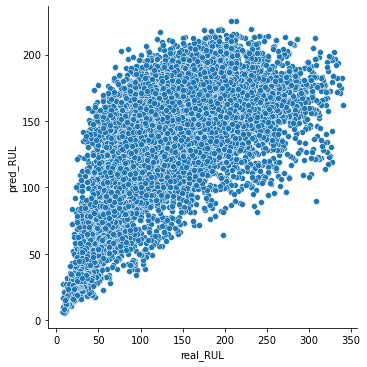

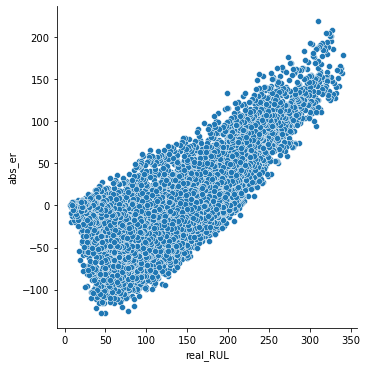

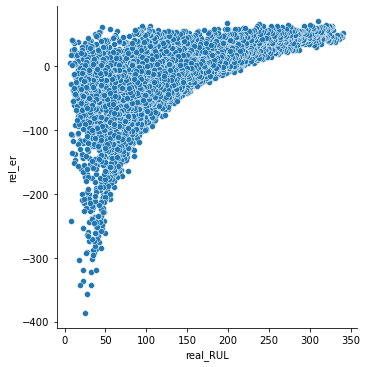

In [21]:
sns.relplot(data = test_df, y = 'pred_RUL', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('RUL.png', bbox_inches='tight', dpi = 300)
sns.relplot(data = test_df, y = 'abs_er', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('absolute_error.png', bbox_inches='tight', dpi = 300)
sns.relplot(data = test_df, y = 'rel_er', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('relative_error.png', bbox_inches='tight', dpi = 300)

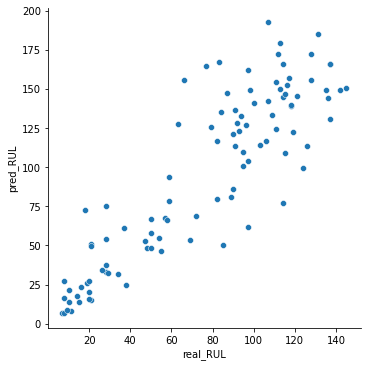

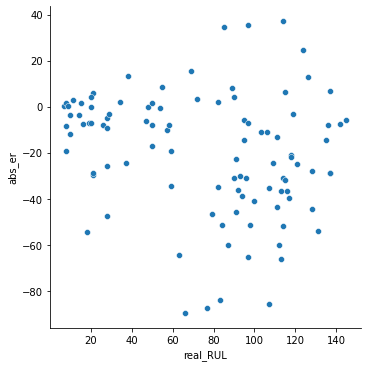

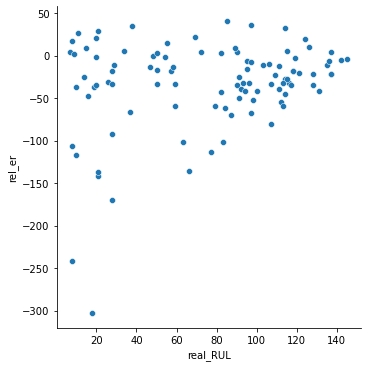

In [17]:
sns.relplot(data = RUL, y = 'pred_RUL', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('RUL.png')
sns.relplot(data = RUL, y = 'abs_er', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('absolute_error.png')
sns.relplot(data = RUL, y = 'rel_er', x='real_RUL', kind = 'scatter', ci=None)
plt.savefig('relative_error.png')

In [10]:
test_df = pd.read_csv('test_df.csv')
test_df.head()
engine_1 = test_df.loc[test_df['engine_no'] == 1]
engine_1['real_RUL'] = RUL.iloc[0,0] - engine_1['time_in_cycles']
engine_1.to_csv('engine_1.csv')

<ipython-input-10-2690d362a5d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_1['real_RUL'] = RUL.iloc[0,0] - engine_1['time_in_cycles']


### Wyznaczenie ilości błędów nie i nadszacowanych

In [21]:
test_df = pd.read_csv('test_df_FD001-1.txt')
a = len(test_df.loc[test_df['abs_er']*test_df['abs_er'] < 121])
b = len(test_df.loc[test_df['abs_er'] < 0])
c = len(test_df.loc[test_df['abs_er'] > 0])
d = len(test_df['abs_er'])
print(a, b, c, d)

3114 7023 6073 13096
